In [34]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers  import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

from dataclasses import dataclass

In [35]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

<h3>Load the Dataset</h3>

In [36]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


<h3>Visualize Sample Iamge </h3>

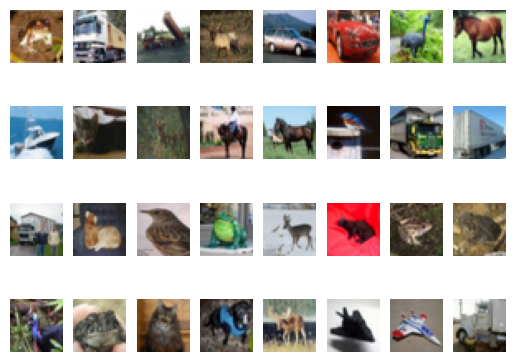

In [37]:
num_row = 4
num_col = 8
for i in range(num_row*num_col):
    plt.subplot(num_row,num_col,i+1)
    plt.imshow(X_train[i,:,:])
    plt.axis('off')

<h3>Data preprocessing</h3>

In [38]:
#Normalize image into range[0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print(f"original integer label for {y_train[0]}")

#convert label to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'converted label for {y_train[0]}')


original integer label for [6]
converted label for [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


<h3>Dataset and Trainingset Parameter config</h3>
<p>Using @dataclass(frozen=True) to define configuration classes is a good practice in machine learning and other projects because it helps to:
-Organize and centralize configuration settings .
-Improve code readability and reduce errors .
-Maintain consistency and immutability in project parameters.</p>

In [39]:
@dataclass(frozen = True)
class Dataconfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001
    

<h3>Define CNN model</h3>

In [40]:
def cnn_model(input_shape=(32, 32, 3)):
    
    model = Sequential()
    #add layer-1 with 32 filter
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape = input_shape))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))# to prevent overfitting.
    
    #add layer-2 with 64 filter
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))# to prevent overfitting.
    
    #add layer-3 with 64 filter
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))# to prevent overfitting.
    
    #Flatten the convolutional features.
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model
    

<h3>Create the model</h3>

In [41]:
cnn_model = cnn_model()
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)         

<h3>Compile the model</h3>

In [42]:
cnn_model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [43]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

<h3>Train the model</h3>

In [44]:
trained_model =  cnn_model.fit(X_train,y_train,
                               batch_size=TrainingConfig.BATCH_SIZE,
                               epochs = TrainingConfig.EPOCHS,
                               verbose = 1,
                               validation_split = .3
                               ) 


Epoch 1/31
137/137 [==============================] - 41s 283ms/step - loss: 2.1128 - accuracy: 0.2253 - val_loss: 1.9395 - val_accuracy: 0.3236
Epoch 2/31
137/137 [==============================] - 37s 267ms/step - loss: 1.7602 - accuracy: 0.3551 - val_loss: 1.6511 - val_accuracy: 0.4187
Epoch 3/31
137/137 [==============================] - 36s 261ms/step - loss: 1.5397 - accuracy: 0.4379 - val_loss: 1.5723 - val_accuracy: 0.4279
Epoch 4/31
137/137 [==============================] - 37s 268ms/step - loss: 1.4092 - accuracy: 0.4916 - val_loss: 1.4106 - val_accuracy: 0.4927
Epoch 5/31
137/137 [==============================] - 36s 261ms/step - loss: 1.2930 - accuracy: 0.5339 - val_loss: 1.2652 - val_accuracy: 0.5489
Epoch 6/31
137/137 [==============================] - 36s 260ms/step - loss: 1.2029 - accuracy: 0.5717 - val_loss: 1.1415 - val_accuracy: 0.5800
Epoch 7/31
137/137 [==============================] - 36s 262ms/step - loss: 1.1128 - accuracy: 0.6032 - val_loss: 1.0594 - val_ac

<h3>Plot the training result with validation</h3>

In [49]:
train_loss = trained_model.history['loss']
train_acc = trained_model.history['accuracy']
val_loss = trained_model.history['val_loss']
val_acc = trained_model.history['val_accuracy']


<h3>Save the Model</h3>

In [50]:
# Using the save() method, the model will be saved to the file system in the 'SavedModel' format.
cnn_model.save("save_model")

INFO:tensorflow:Assets written to: save_model\assets


INFO:tensorflow:Assets written to: save_model\assets


ImportError: cannot import name '__version__' from 'tensorflow.python.keras' (c:\Python312\Lib\site-packages\tensorflow\python\keras\__init__.py)